In [200]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

In [201]:
#Path management 

def list_directory_tree_with_os_walk(starting_directory):
    for root, directories, files in os.walk(starting_directory):
        print(f"Directory: {root}")
        for file in files:
            print(f"  File: {file}")

# Check the directory
starting_directory_noe = 'C:/Users/Noe/source/repos/Energy-forecasting-NTNU/data/'
starting_directory_hugo = 'C:/Users/hugob/OneDrive/Documents/ENSE3/3A/lectures/Machine Learning/Project/git/Energy-forecasting-NTNU/data'
os.chdir(starting_directory_hugo)
list_directory_tree_with_os_walk('.')

Directory: .
  File: .DS_Store
  File: Readme.md
  File: read_files.ipynb
  File: sample_submission.csv
  File: test.csv
Directory: .\.ipynb_checkpoints
  File: Data_exploration-checkpoint.ipynb
  File: Readme-checkpoint.md
  File: read_files-checkpoint.ipynb
Directory: .\A
  File: train_targets.parquet
  File: X_test_estimated.parquet
  File: X_train_estimated.parquet
  File: X_train_observed.parquet
Directory: .\B
  File: train_targets.parquet
  File: X_test_estimated.parquet
  File: X_train_estimated.parquet
  File: X_train_observed.parquet
Directory: .\C
  File: train_targets.parquet
  File: X_test_estimated.parquet
  File: X_train_estimated.parquet
  File: X_train_observed.parquet
Directory: .\Hugo
  File: notebook_hugo.ipynb
  File: read_files.ipynb
Directory: .\Noe
  File: Data_exploration.ipynb
  File: read_files.ipynb


In [202]:
#Load datasets #
#Targets
train_a = pd.read_parquet('A/train_targets.parquet')
train_b = pd.read_parquet('B/train_targets.parquet')
train_c = pd.read_parquet('C/train_targets.parquet')

# Train estimated data
X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('C/X_train_estimated.parquet')

# Train observed data
X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('C/X_train_observed.parquet')

Train_datasets = [X_train_observed_a, X_train_observed_b, X_train_observed_c, 
            X_train_estimated_a, X_train_estimated_b,X_train_estimated_c
            ]
Train_datasets_names = [ "X_train_observed_a", "X_train_observed_b", "X_train_observed_c",
                        "X_train_estimated_a", "X_train_estimated_b", "X_train_estimated_c"
                        ]

Target_datasets = [train_a, train_b, train_c]

### Quick data management for missing values

In [203]:
# Remove snow_density variable because too many Nan ==> Useless
for i, dataset in enumerate(Train_datasets):
    dataset = dataset.drop(columns = 'snow_density:kgm3')
    Train_datasets[i] = dataset

In [204]:
# Function to fill gaps in dataset
def fill_nan(Dataframe, feature):
    it_na = np.where(Dataframe[feature].isna())[0]
    
    #If missing value
    if len(it_na != 0):
        method = 'ffill' # ffill: Propagate last valid observation forward to next valid
        new_column = Dataframe[feature].fillna(method='ffill')
        
        if((np.any(new_column.isna()) == True)): 
            method = 'bfill' # bfill :Fill values by using the next valid observation to fill the gap.
            new_column = Dataframe[feature].fillna(method='bfill')
    
        if (np.any(new_column.isna()) == False):
            print("==> ", feature, " filled with ",method," method")
            Dataframe[feature] = new_column
        else:
            print("Still Nan values !!!")

In [205]:
# Fill for each train dataset for each variable where there is some Nan
for i, dataset in enumerate(Train_datasets):
    print("Dataset : ",  Train_datasets_names[i])
    nan_features = [var for var in dataset.columns if dataset[var].isnull().sum() > 0]
    for features in nan_features:
        fill_nan(dataset, features)
    print("\n")

Dataset :  X_train_observed_a
==>  ceiling_height_agl:m  filled with  ffill  method
==>  cloud_base_agl:m  filled with  ffill  method


Dataset :  X_train_observed_b
==>  ceiling_height_agl:m  filled with  ffill  method
==>  cloud_base_agl:m  filled with  ffill  method


Dataset :  X_train_observed_c
==>  ceiling_height_agl:m  filled with  ffill  method
==>  cloud_base_agl:m  filled with  ffill  method


Dataset :  X_train_estimated_a
==>  ceiling_height_agl:m  filled with  ffill  method
==>  cloud_base_agl:m  filled with  ffill  method


Dataset :  X_train_estimated_b
==>  ceiling_height_agl:m  filled with  ffill  method
==>  cloud_base_agl:m  filled with  ffill  method


Dataset :  X_train_estimated_c
==>  ceiling_height_agl:m  filled with  ffill  method
==>  cloud_base_agl:m  filled with  ffill  method




### Feature engineering

In [206]:
# Check for correlation
set_nbr = 0
corr_matrix = Train_datasets[set_nbr].corr()
print(Train_datasets_names[set_nbr])
corr_matrix.style.background_gradient(cmap='coolwarm')

X_train_observed_a


c:\Users\hugob\anaconda3\lib\site-packages\pandas\io\formats\style.py:3555: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
c:\Users\hugob\anaconda3\lib\site-packages\pandas\io\formats\style.py:3556: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms
absolute_humidity_2m:gm3,1.000000,-0.804124,0.110840,0.352801,0.349927,0.024787,0.123430,0.974863,0.284847,0.291109,0.239287,0.243773,0.021256,nan,-0.119009,-0.069179,-0.148714,-0.085105,-0.098863,0.304652,-0.322754,0.147830,0.067724,-0.025242,0.165345,0.154403,-0.055802,0.261640,0.160016,0.143458,-0.203685,nan,-0.013563,0.034042,0.022875,0.432344,0.110364,0.900297,0.043038,-0.158686,-0.157917,0.050106,-0.258794,0.004869
air_density_2m:kgm3,-0.804124,1.000000,-0.159707,-0.473967,-0.463355,-0.105238,-0.060455,-0.838733,-0.402079,-0.415496,-0.393769,-0.409485,-0.067100,nan,0.063038,0.044146,0.075154,0.052815,0.058816,-0.386344,0.402335,0.280098,-0.084777,-0.012127,0.263756,0.275654,0.072122,-0.162900,0.141432,0.287484,0.316890,nan,0.013984,-0.065673,-0.067960,-0.504503,-0.063599,-0.915070,-0.103049,-0.011076,-0.017527,0.026196,0.142869,-0.000575
ceiling_height_agl:m,0.110840,-0.159707,1.000000,0.071831,0.066778,0.664970,0.037937,0.101108,0.055368,0.058749,0.236082,0.243613,-0.377015,nan,-0.018965,-0.010354,-0.026045,-0.014081,-0.016165,0.052470,-0.056461,0.097773,-0.012913,-0.063670,0.102267,0.099780,0.025814,-0.150385,-0.388320,0.097302,-0.061680,nan,-0.028779,-0.179834,0.040713,0.078340,-0.322444,0.255581,-0.187227,0.423864,-0.172588,-0.305707,-0.010682,-0.003096
clear_sky_energy_1h:J,0.352801,-0.473967,0.071831,1.000000,0.992332,0.053497,-0.080023,0.362016,0.911178,0.922412,0.719660,0.732282,0.002814,nan,-0.056605,-0.037862,-0.072751,-0.046583,-0.052732,0.650795,-0.690138,0.157747,-0.008042,-0.032567,0.160357,0.154124,-0.050700,0.054178,-0.339914,0.147883,-0.074640,nan,-0.020592,-0.039219,0.056788,0.847872,0.016904,0.438994,0.009891,0.092573,0.013025,0.069513,-0.343041,-0.005087
clear_sky_rad:W,0.349927,-0.463355,0.066778,0.992332,1.000000,0.050362,-0.079422,0.359138,0.917222,0.914733,0.727173,0.728482,0.003273,nan,-0.055061,-0.037588,-0.072560,-0.045965,-0.051830,0.651263,-0.693266,0.158353,-0.009060,-0.032314,0.160647,0.154566,-0.050494,0.052233,-0.313417,0.148472,-0.074147,nan,-0.020584,-0.041589,0.002422,0.851637,0.017788,0.424912,0.009648,0.083516,0.003153,0.063870,-0.327927,-0.006878
cloud_base_agl:m,0.024787,-0.105238,0.664970,0.053497,0.050362,1.000000,0.029038,0.018957,0.016105,0.019863,0.246256,0.252961,-0.394619,nan,-0.013806,-0.008638,-0.016642,-0.012054,-0.014636,0.027712,-0.029643,0.089278,-0.032314,-0.079654,0.092751,0.091005,0.031311,-0.117894,-0.467114,0.089255,-0.064314,nan,-0.019182,-0.134643,0.036471,0.048875,-0.274170,0.204864,-0.215561,0.449480,-0.208237,-0.377859,0.028942,0.001733
dew_or_rime:idx,0.123430,-0.060455,0.037937,-0.080023,-0.079422,0.029038,1.000000,0.123717,-0.080196,-0.081953,-0.055274,-0.056277,-0.050331,nan,-0.010698,-0.009383,-0.013659,-0.009211,-0.010723,-0.105438,0.102463,0.005786,-0.009744,-0.016899,0.009538,0.008596,-0.177816,-0.007136,0.100292,0.007660,-0.015160,nan,-0.003851,-0.022419,-0.039829,-0.072291,-0.036164,0.109030,-0.033482,-0.031053,-0.108146,-0.038802,0.005134,-0.001638
dew_point_2m:K,0.974863,-0.838733,0.101108,0.362016,0.359138,0.018957,0.123717,1.000000,0.296786,0.303062,0.245491,0.250216,0.059003,nan,-0.126655,-0.076161,-0.156335,-0.092939,-0.106866,0.310899,-0.329485,0.137601,0.065673,-0.025590,0.155653

In [207]:
#Find high correlated variables in train datasets
List_correlated_variable = []

for set_nbr in range(len(Train_datasets)):
    corr_matrix = Train_datasets[set_nbr].corr()
    threshold = 0.95

    idx = np.where((np.abs(corr_matrix) > threshold) & (corr_matrix !=1))
    print(round(idx[0].shape[0]/2)," strong correlation ==> \n")
    columns_corr = []
    ind_double = []

    # To select the correct variable (without time and time forecast in the pandaframe)
    if set_nbr > 2:
        add_int = 2
    else:
        add_int = 1

    for i in range(idx[0].shape[0]):
        if ( ind_double.count((idx[0][i],idx[1][i])) == 0):
            ind_double.append((idx[1][i],idx[0][i]))
            
            print( 
                    "Correlation between : ", 
                    Train_datasets[set_nbr].columns[idx[0][i]+add_int], "and", 
                    Train_datasets[set_nbr].columns[idx[1][i]+add_int], " = ",
                    corr_matrix.iloc[idx[0][i], idx[1][i]], "\n"
                )
            
            columns_corr.append((Train_datasets[set_nbr].columns[idx[0][i]+add_int],
                                Train_datasets[set_nbr].columns[idx[1][i]+add_int]
                                ))
            List_correlated_variable.append(columns_corr)

10  strong correlation ==> 

Correlation between :  absolute_humidity_2m:gm3 and dew_point_2m:K  =  0.9748628282981654 

Correlation between :  clear_sky_energy_1h:J and clear_sky_rad:W  =  0.9923317834232241 

Correlation between :  diffuse_rad:W and diffuse_rad_1h:J  =  0.9869871153005173 

Correlation between :  direct_rad:W and direct_rad_1h:J  =  0.9852611696388884 

Correlation between :  msl_pressure:hPa and pressure_100m:hPa  =  0.9997717603345274 

Correlation between :  msl_pressure:hPa and pressure_50m:hPa  =  0.999914482392545 

Correlation between :  msl_pressure:hPa and sfc_pressure:hPa  =  0.9999042081912317 

Correlation between :  pressure_100m:hPa and pressure_50m:hPa  =  0.9999178389342016 

Correlation between :  pressure_100m:hPa and sfc_pressure:hPa  =  0.9996884691072808 

Correlation between :  pressure_50m:hPa and sfc_pressure:hPa  =  0.9999182187872183 

10  strong correlation ==> 

Correlation between :  absolute_humidity_2m:gm3 and dew_point_2m:K  =  0.97361

We can see same correlation appears for all the datasets
==> Thus we can remove one of the varaible each time except for pressure variables which seem to be all correlated together

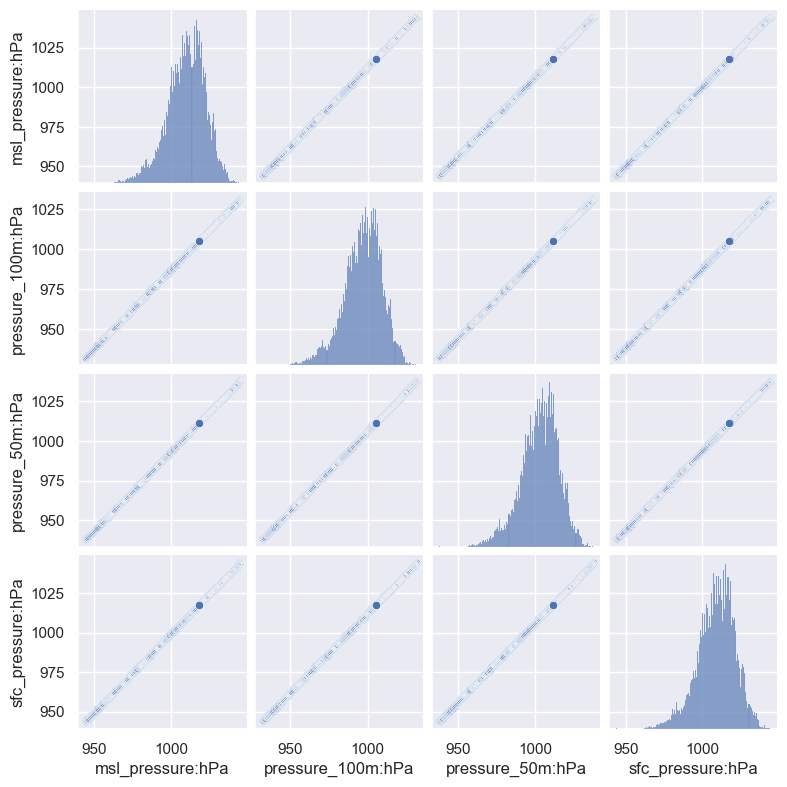

In [208]:
sns.set()
cols_pressure = ['msl_pressure:hPa', 'pressure_100m:hPa', 'pressure_50m:hPa', 'sfc_pressure:hPa']
sns.pairplot(Train_datasets[0][cols_pressure], height = 2)
plt.show()

In [209]:
high_correlated_var = [
    "dew_point_2m:K",
    "clear_sky_energy_1h:J",
    "diffuse_rad_1h:J",
    "direct_rad_1h:J",
    "msl_pressure:hPa",
    "pressure_50m:hPa",
    "sfc_pressure:hPa"
]
for i, dataset in enumerate(Train_datasets):
    dataset = dataset.drop(columns = high_correlated_var)
    Train_datasets[i] = dataset

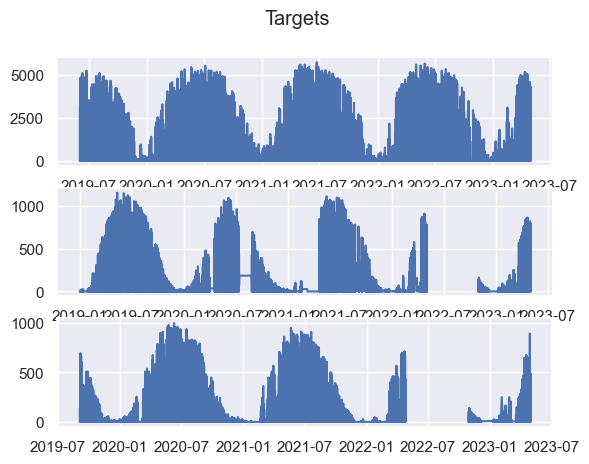

In [217]:
fig, (ax1, ax2, ax3) = plt.subplots(3)
fig.suptitle('Targets')
ax1.plot(train_a.iloc[:,0], train_a.iloc[:,1])
ax2.plot(train_b.iloc[:,0], train_b.iloc[:,1])
ax3.plot(train_c.iloc[:,0], train_c.iloc[:,1])
plt.show()

In [221]:
location = ["A", "B", "C"]
for i in range(3):
    print("Location ", location[i])
    print("Observed data : ", Train_datasets[i].iloc[0,0]," to ", Train_datasets[i].iloc[-1,0])
    print("Forecast data : ", Train_datasets[i+3].iloc[0,0]," to ", Train_datasets[i+3].iloc[-1,0])
    print("Target : ", Target_datasets[i].iloc[0,0]," to ", Target_datasets[i].iloc[-1,0] )
    print("\n")

Location  A
Observed data :  2019-06-02 22:00:00  to  2022-10-21 01:00:00
Forecast data :  2022-10-27 07:00:18  to  2023-04-29 07:00:05
Target :  2019-06-02 22:00:00  to  2023-04-30 23:00:00


Location  B
Observed data :  2019-01-01 00:00:00  to  2022-05-03 00:00:00
Forecast data :  2022-10-27 07:00:18  to  2023-04-29 07:00:05
Target :  2018-12-31 23:00:00  to  2023-04-30 23:00:00


Location  C
Observed data :  2019-01-01 00:00:00  to  2022-05-01 22:00:00
Forecast data :  2022-10-27 07:00:18  to  2023-04-29 07:00:05
Target :  2018-12-31 23:00:00  to  2023-04-30 23:00:00


